In [37]:
import os
from dotenv import load_dotenv
load_dotenv()
# Define the bucket name and region
S3_BUCKET = os.getenv("S3_BUCKET")
S3_PREFIX = os.getenv("S3_PREFIX")
REGION = os.getenv("REGION")
SAGE_MAKER_LOCAL_ROLE = os.getenv("SAGE_MAKER_LOCAL_ROLE")
print(f"S3_BUCKET: {S3_BUCKET}")
print(f"REGION: {REGION}")
print(f"SAGE_MAKER_LOCAL_ROLE: {SAGE_MAKER_LOCAL_ROLE}")

S3_BUCKET: sgmkr-thangtran3112
REGION: us-west-2
SAGE_MAKER_LOCAL_ROLE: arn:aws:iam::123456789012:role/service-role/AmazonSageMaker-ExecutionRole-20191231T123456


In [8]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from IPython.display import Image

import boto3
import logging

boto3.set_stream_logger(name="botocore.credentials", level=logging.WARNING)

#### Iris Dataset

In [9]:
Image(url="images/iris_1.png", width=800)  # , height=300)

In [10]:
Image(url="images/iris_2.svg", width=800)  # , height=300)

In [11]:
Image(url="images/iris_3.png", height=400)

In [12]:
# https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset
iris = datasets.load_iris()
type(iris)

sklearn.utils._bunch.Bunch

In [13]:
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [14]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [15]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
# Add the "class" column to the DataFrame
df["class"] = pd.Series(iris.target)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [16]:
# target_names: will be [0, 1, 2] corresponding to the 3 classes: "setosa", "versicolor", "virginica"
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [17]:
print(df.shape)

(150, 5)


In [18]:
# How many samples are there for each class in this dataset?
df["class"].value_counts()

class
0    50
1    50
2    50
Name: count, dtype: int64

In [19]:
# This part has been fixed into the next cell, to avoid the case where the "class" column is not the last one
'''
cols = list(df.columns)
print(cols)
# Move the "class" column to the front of the DataFrame, as it is required by xgboost of SageMaker
cols = [cols[-1]] + cols[:-1] # cols[:-1] is all columns except the last one
print(cols)
df = df[cols]
df.head()
'''

'\ncols = list(df.columns)\nprint(cols)\n# Move the "class" column to the front of the DataFrame, as it is required by xgboost of SageMaker\ncols = [cols[-1]] + cols[:-1] # cols[:-1] is all columns except the last one\nprint(cols)\ndf = df[cols]\ndf.head()\n'

In [20]:
cols = list(df.columns)
print(cols)
# Move the "class" column to the front of the DataFrame, as it is required by xgboost of SageMaker
cols.insert(0, cols.pop(cols.index('class')))
print(cols)
df = df[cols]
df.head()

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'class']
['class', 'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,class,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2


#### Train - Test split

In [21]:
# Split the dataset into training and testing sets with stratification based on the "class" column
# 0.33 means 33% of the data will be used for testing
train_df, test_df = train_test_split(
    df, test_size=0.33, random_state=42, stratify=df["class"]
)

In [22]:
# number of samples in the training set, after stratification
train_df["class"].value_counts()

class
0    34
2    33
1    33
Name: count, dtype: int64

In [23]:
# number of samples in the testing set, after splitting
test_df["class"].value_counts()

class
2    17
1    17
0    16
Name: count, dtype: int64

In [24]:
from pathlib import Path

data_dir = Path("data")
try:
    data_dir.mkdir(exist_ok=True)
    print(f"Directory ready: {data_dir}")
except PermissionError:
    print(f"Error: No permission to create directory {data_dir}")

Directory ready: data


In [25]:
# index=False: Prevents writing the DataFrame's index as a column in the CSV
# header=None: Suppresses writing column names as the first row of the CSV
# As the training data can only be numbers, we don't need the column names
train_df.to_csv("data/iris_train.csv", index=False, header=None)

In [26]:
test_df.to_csv("data/iris_test.csv", index=False, header=None)

In [27]:

# Drop the "class" column from the test_df to create infer_df for inference
infer_df = test_df.drop(columns=["class"])
infer_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
133,6.3,2.8,5.1,1.5
56,6.3,3.3,4.7,1.6
7,5.0,3.4,1.5,0.2
67,5.8,2.7,4.1,1.0
107,7.3,2.9,6.3,1.8


In [28]:
infer_df.to_csv("data/iris_infer.csv", index=False, header=None)

In [29]:
# Execute shell command to display the first few lines of the training data, default is 10 lines. 
# class is the first column, followed by the 4 features
!head data/iris_train.csv

2,6.3,3.4,5.6,2.4
0,5.1,3.5,1.4,0.3
2,5.8,2.7,5.1,1.9
1,5.2,2.7,3.9,1.4
0,4.6,3.4,1.4,0.3
0,5.2,4.1,1.5,0.1
0,5.7,4.4,1.5,0.4
2,6.4,3.1,5.5,1.8
0,4.8,3.1,1.6,0.2
0,4.9,3.1,1.5,0.2


In [30]:
# class column has been removed from the infer data
!head data/iris_infer.csv

6.3,2.8,5.1,1.5
6.3,3.3,4.7,1.6
5.0,3.4,1.5,0.2
5.8,2.7,4.1,1.0
7.3,2.9,6.3,1.8
4.9,2.4,3.3,1.0
5.7,2.8,4.5,1.3
5.7,3.8,1.7,0.3
5.6,3.0,4.5,1.5
5.5,2.3,4.0,1.3


In [31]:
import boto3
from botocore.exceptions import ClientError

# Initialize S3 client with the specified region
s3_client = boto3.client('s3', region_name=REGION)

# Function to check if bucket exists
def bucket_exists(bucket_name):
    try:
        s3_client.head_bucket(Bucket=bucket_name)
        return True
    except ClientError:
        return False

# Function to create bucket if it doesn't exist
def create_bucket(bucket_name, region):
    try:
        if not bucket_exists(bucket_name):
            s3_client.create_bucket(
                Bucket=bucket_name,
                CreateBucketConfiguration={'LocationConstraint': region}
            )
            print(f"Bucket '{bucket_name}' created successfully in region '{region}'.")
        else:
            print(f"Bucket '{bucket_name}' already exists.")
    except ClientError as e:
        print(f"Error creating bucket: {e}")

# Create the bucket
create_bucket(S3_BUCKET, REGION)

Bucket 'sgmkr-thangtran3112' already exists.


In [32]:
# Upload the training data to S3, aws-cli must be installed and configured
# Must make sure the notebook instance has the necessary permissions to access S3
!aws s3 cp data/iris_train.csv s3://{S3_BUCKET}/{S3_PREFIX}/data/

upload: data/iris_train.csv to s3://sgmkr-thangtran3112/iris/data/iris_train.csv


In [33]:
!aws s3 cp data/iris_test.csv s3://{S3_BUCKET}/{S3_PREFIX}/data/

upload: data/iris_test.csv to s3://sgmkr-thangtran3112/iris/data/iris_test.csv


In [34]:
!aws s3 cp data/iris_infer.csv s3://{S3_BUCKET}/{S3_PREFIX}/batch_transform/

upload: data/iris_infer.csv to s3://sgmkr-thangtran3112/iris/batch_transform/iris_infer.csv


In [35]:
import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

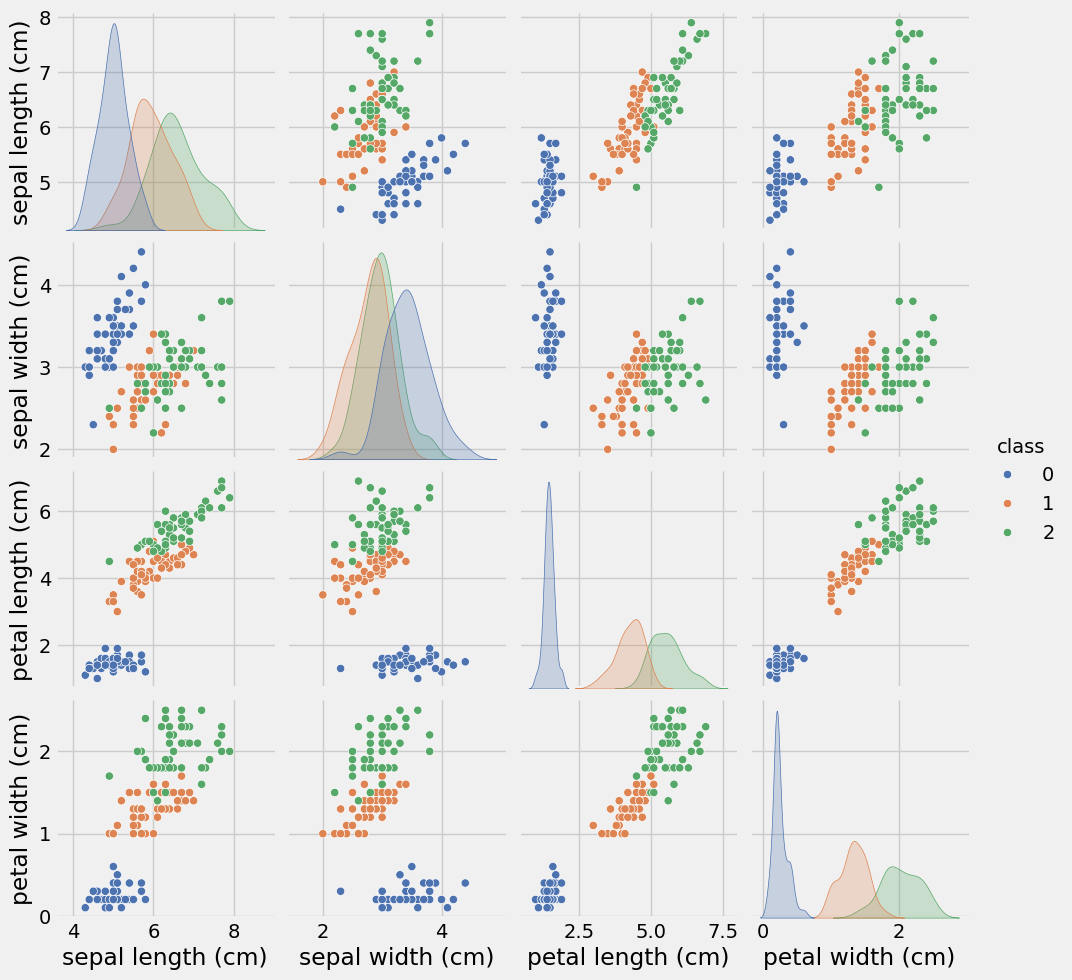

In [36]:
sb.pairplot(df, hue="class", palette="deep")
plt.show()

In the above graph, we can clearly see that the `petal width` and `petal length` distributions, will likely to have more weights in determining the type of iris